In [46]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance

from utils import manage_outlier

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

# plt.rcParams['font.family'] = 'Malgun Gothic'
warnings.filterwarnings('ignore')
seed_everything()

In [199]:
df = pd.read_csv('./dataset/ff.csv')

def make_targets(targets):
    return 1 if targets >=5 else 0

# df['BE3_31'] = df.apply(
#     lambda row: make_targets(row['BE3_31']), axis=1
# )
df['BE5_1'] = df.apply(
    lambda row: make_targets(row['BE5_1']), axis=1
)
drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
display(drops[:10])
df = df[drops[drops.values <= 10].index]

drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
display(drops[:10])

HE_cough1    23.867550
HE_sput1     23.867550
EC_pedu_1    23.682119
EC_pedu_2    20.503311
HE_DM        16.529801
BD7_4        15.072848
BD7_5        13.086093
BH9_11       11.735099
BP6_10       10.728477
BP5          10.622517
dtype: float64

BS5_1      4.582781
occp       1.748344
EC1_1      1.589404
edu        1.589404
BE3_31     1.509934
LQ4_00     1.509934
LQ_4EQL    1.483444
LQ1_sb     1.456954
BH2_61     1.456954
LQ1_mn     1.456954
dtype: float64

In [200]:
# feature importance 기반 변수 제거(1차)
df.drop(['LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL'], axis=1, inplace=True)
# feature importance 기반 변수 제거(2차) X
# df.drop(['BS5_1'], axis=1, inplace=True)
# corr matrix 기반 변수 제거(3차)
df.drop(['EC1_1'], axis=1, inplace=True)
# feature importance 기반 변수 제거(4차) X
# df.drop(['D_1_1'], axis=1, inplace=True)
# feature importance 기반 변수 제거(5차)
df.drop(['cage', 'LQ1_sb', 'BP1', 'LQ1_mn'], axis=1, inplace=True)
# 분산 기반 변수 제거(6차)
df.drop(['BS6_2_1', 'BS6_3'], axis=1, inplace=True)
# feture importance 기반 변수 제거(7차)
df.drop(['LQ4_00', 'BD1'], axis=1, inplace=True)

In [201]:
# 1차년도
NUMERIC = ['HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
f_CATEGORICAL = (CATEGORICAL + CATEGORICAL2 + CATEGORICAL3).copy()
f_ONE_HOT = (ONE_HOT + ONE_HOT2 + ONE_HOT3).copy()

In [206]:
for value in f_NUMERIC:
    if value not in df.columns:
        print(value)
        f_NUMERIC.remove(value)

for value in f_CATEGORICAL:
    if value not in df.columns:
        print(value)
        f_CATEGORICAL.remove(value)

for value in f_ONE_HOT:
    if value not in df.columns:
        print(value)
        f_ONE_HOT.remove(value)

In [207]:
f_ONE_HOT.append('BE3_31')

In [208]:
# 결측치 처리
for col in df.columns:
    # df[col].fillna(df[col].mode()[0], inplace=True)
    df[col].fillna(0, inplace=True)

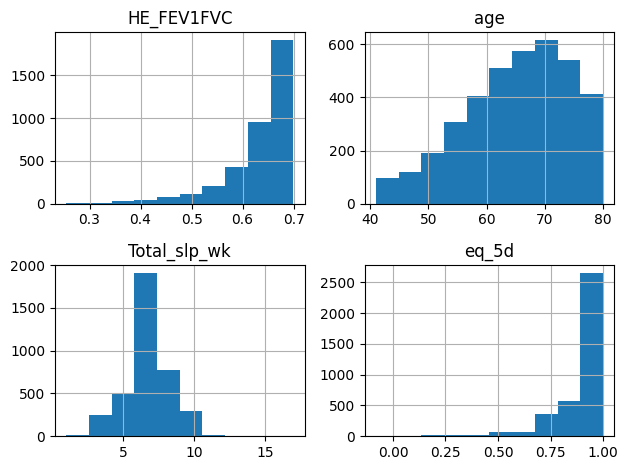

In [209]:
df[f_NUMERIC].hist()
plt.tight_layout()
plt.show()

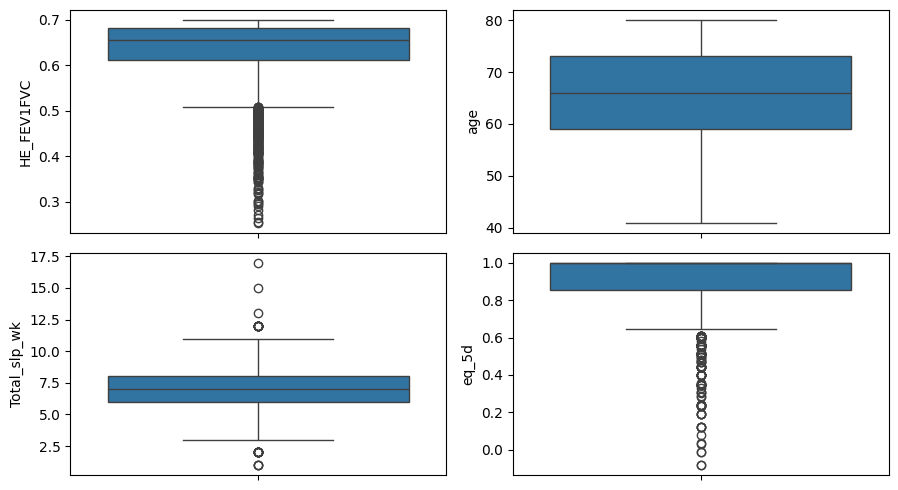

In [210]:
cols = 2
rows = 2
fig, axes = plt.subplots(cols, rows, figsize=(9, 5))

count = 0
for j in range(cols):
    for k in range(rows):
        if count >= 7:
            break
        sns.boxplot(y=df[f_NUMERIC[count]], ax=axes[j, k])
        count += 1
plt.tight_layout()

In [211]:
# 이상치 제거
for col in f_NUMERIC:
    print(col)
    manage_outlier(df, col)

HE_FEV1FVC
245개 삭제
age
0개 삭제
Total_slp_wk
28개 삭제
eq_5d
152개 삭제


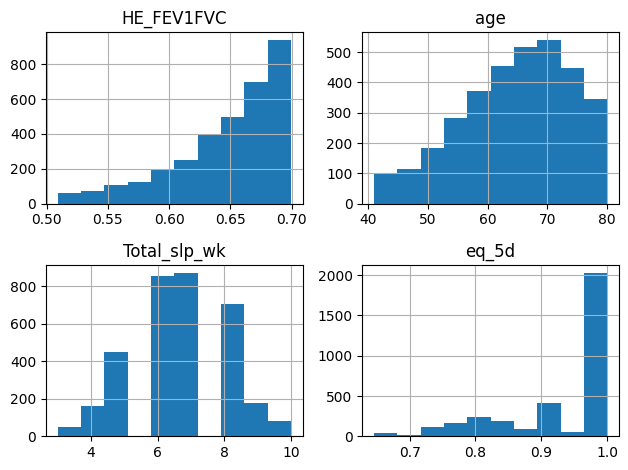

In [212]:
df[f_NUMERIC].hist()
plt.tight_layout()
plt.show()

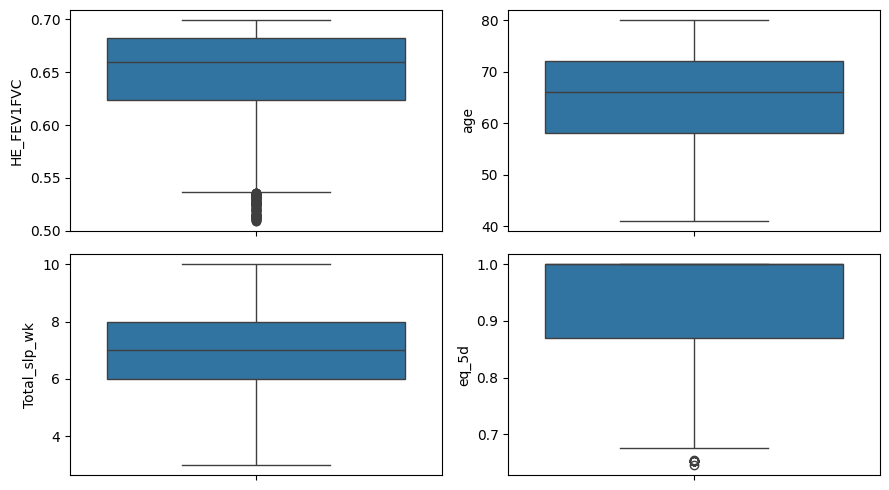

In [213]:
cols = 2
rows = 2
fig, axes = plt.subplots(cols, rows, figsize=(9, 5))

count = 0
for j in range(cols):
    for k in range(rows):
        if count >= 7:
            break
        sns.boxplot(y=df[f_NUMERIC[count]], ax=axes[j, k])
        count += 1
plt.tight_layout()

In [214]:
X = df.drop('BE5_1', axis=1)
y = df['BE5_1']

X_numeric = X[f_NUMERIC]
X_categorical = X[f_CATEGORICAL]
X_onehot = X[f_ONE_HOT]

In [215]:
X_onehot['BE3_31'].replace({
    0:'0일',
    1:'1일',
    2:'2일',
    3:'3일',
    4:'4일',
    5:'5일',
    6:'6일',
    7:'7일',
}, inplace=True)
X_onehot = pd.get_dummies(X_onehot, dtype=float)
X = pd.concat([X_numeric, X_categorical], axis=1)
X = pd.concat([X, X_onehot], axis=1)

In [216]:
# split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)
scaler = StandardScaler()
train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=scaler.feature_names_in_)
test_X = pd.DataFrame(scaler.transform(test_X), columns=scaler.feature_names_in_)

In [217]:
# no oversampling
params = {
    'n_estimators': 300, 
    'max_depth': 12, 
    # 'learning_rate': 0.009, 
    'learning_rate': 0.008, 
    # 'gamma': 0,
    # 'alpha': 0, 
    # 'lambda': 0, 
    'min_child_weight': 6, 
    'max_delta_step': 26, 
    'subsample': 0.6, 
    'sampling_method': 'uniform', 
    'tree_method': 'approx', 
    'grow_policy': 'depthwise', 
    'max_bin': 300, 
    'scale_pos_weight': 8
}
model = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **params)
model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.008, max_bin=300,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=26,
              max_depth=12, max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [218]:
print(classification_report(train_y, model.predict(train_X)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      2376
           1       0.64      0.98      0.77       304

    accuracy                           0.94      2680
   macro avg       0.82      0.95      0.87      2680
weighted avg       0.96      0.94      0.94      2680



In [219]:
print(classification_report(test_y, model.predict(test_X)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       594
           1       0.34      0.46      0.39        76

    accuracy                           0.84       670
   macro avg       0.63      0.67      0.65       670
weighted avg       0.86      0.84      0.85       670



<Axes: >

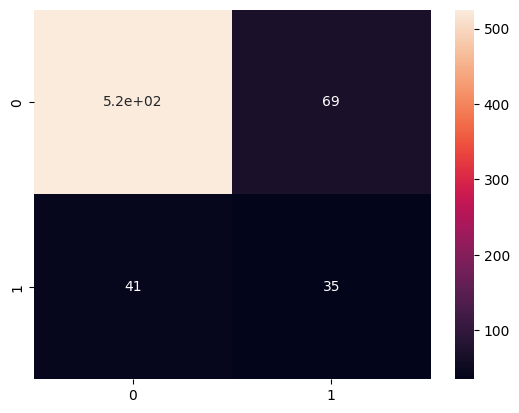

In [220]:
sns.heatmap(confusion_matrix(test_y, model.predict(test_X)), annot=True)

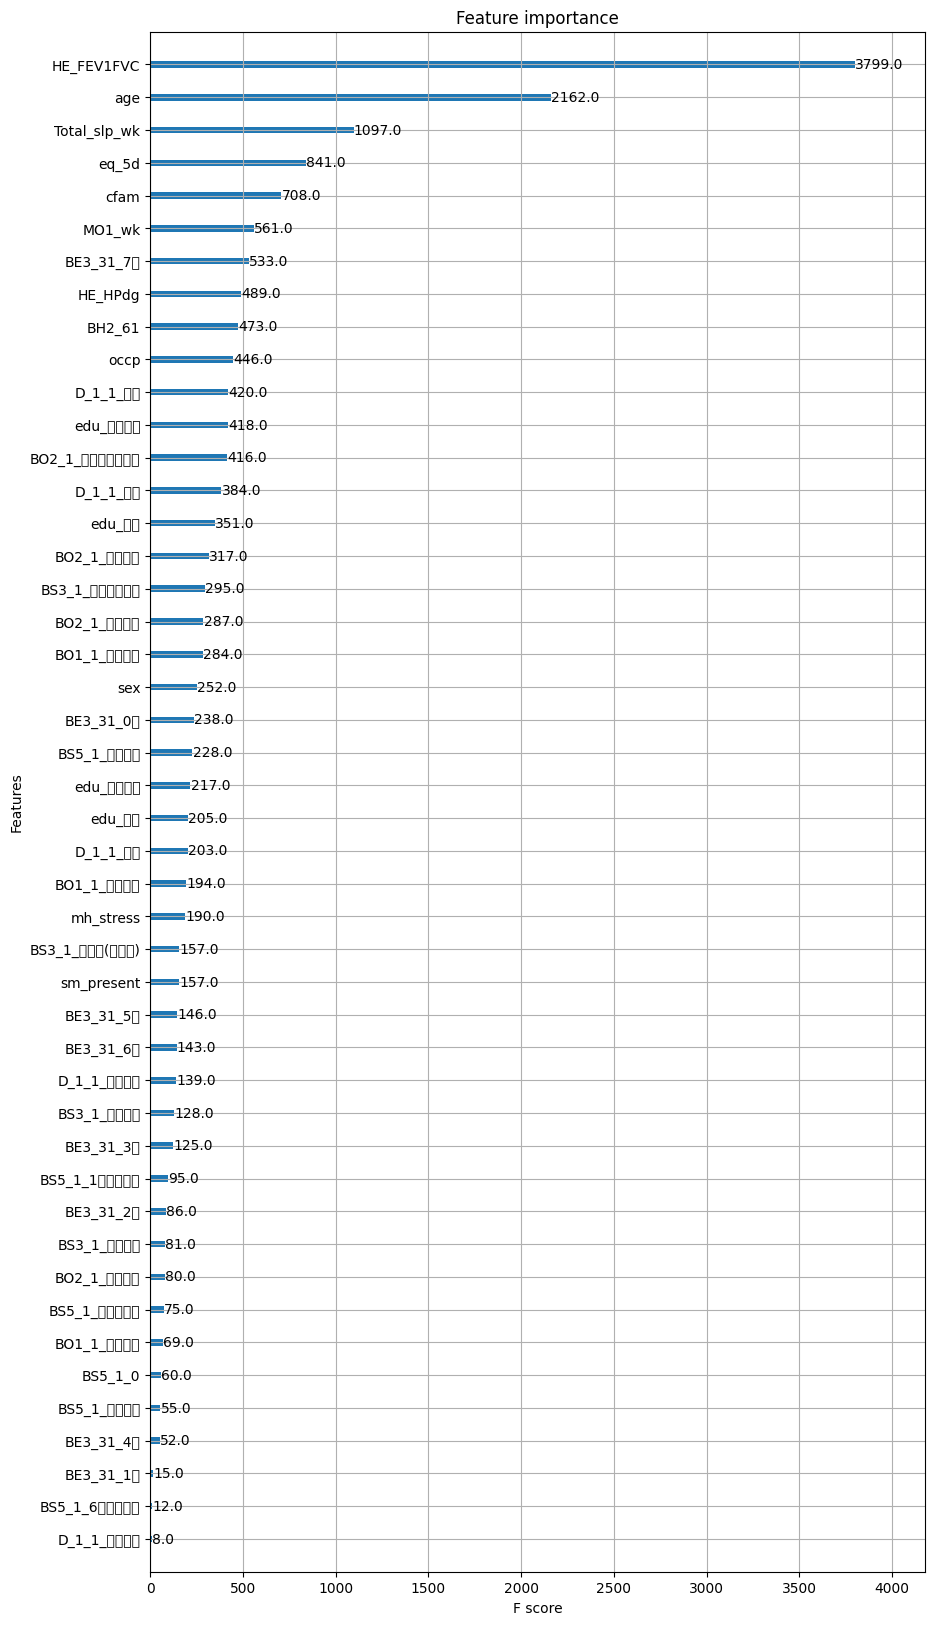

In [221]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_importance(model, ax=ax)
plt.show()